In [10]:
import pandas as pd
import umap
import umap.plot
import matplotlib.pyplot as plt
import hdbscan
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns
import sklearn

from scipy.stats import kruskal
from scipy.stats import wilcoxon
from scipy.stats import f_oneway
from scikit_posthocs import posthoc_dunn
import skbio

from skbio import DistanceMatrix
from skbio.stats.distance import permanova

import scipy.stats as stats
from helpers import *

In [2]:
patient_data = pd.read_csv("../output_data/matched_patients_without_replacement.csv")
patient_data.set_index("participantid", inplace=True)

bladder_health_cols = ["bhs_1", "bhs_2", "bhs_3", "bhs_4", "bhs_5", "bhs_6", "bhs_7", "bhs_8",
                       "bhs_9", "bhs_10", "bfi_biosis", "bfi_freq", "bfi_sensation", "bfi_continence",
                       "bfi_comfort", "bfi_emptying"]
bladder_health_cols_adj = ["bhs_1_adj", "bhs_2_adj", "bhs_3_adj", "bhs_4_adj", "bhs_5_adj", "bhs_6_adj", "bhs_7_adj",
                            "bhs_8_adj", "bhs_9_adj", "bhs_10_adj", "bfi_overall"]
cancer_patients = patient_data[(patient_data["cancer"] == True) & (patient_data["absolute_propensity_difference"] < 0.01)].index.tolist()
controls = patient_data.loc[cancer_patients]["nearest_patient"].to_list()

patient_data_bladder_health = patient_data[ bladder_health_cols]
patient_data_bladder_health_adj = patient_data[ bladder_health_cols_adj]

In [5]:
patient_data.loc[cancer_patients]

,b1_age,b1_e1,b1_e2,b1_e3,b1_e4_ft,b1_e4_in,b1_e4_cm,b1_e5_lbs,b1_e5_kg,b1_e6,...,bhs_9_adj,bhs_10_adj,bfi_overall,bh_urobiome_barcode,pass_kseq_threshold,sample_type,cancer,propensity_score,nearest_patient,absolute_propensity_difference
participantid,,,,,,,,,,,,,,,,,,,,,
YU015,31.0,1.0,2.0,5,5,7,NaN,168,NaN,0.0,...,95.774648,78.048780,93.859649,X00232568,y,research,True,0.011715,UA084,0.000017
WU087,64.0,1.0,2.0,5,5,7,NaN,179,NaN,0.0,...,13.380282,8.943089,35.087719,X00232718,y,research,True,0.040902,YU092,0.000004
UP179,44.0,2.0,2.0,5,5,8,NaN,168,NaN,0.0,...,87.323944,92.682927,82.456140,X00233200,n,research,True,0.045304,LU137,0.000085
UM081,52.0,1.0,1.0,5,5,11,NaN,190,NaN,0.0,...,100.000000,100.000000,94.736842,X00233690,n,research,True,0.065960,UM228,0.000226
NU018,74.0,2.0,2.0,4,5,7,NaN,198,NaN,0.0,...,30.281690,26.829268,50.000000,X00233904,y,pilot2,True,0.085228,UA044,0.000196
LU048,60.0,0.0,2.0,5,5,8,NaN,244,NaN,0.0,...,77.464789,77.235772,94.736842,X00232524,y,pilot2,True,0.090376,YU242,0.000087
EM058,52.0,1.0,2.0,5,5,0,NaN,122,NaN,0.0,...,NaN,NaN,43.045113,X00233342,n,research,True,0.099417,UP034,0.001879
WU227,65.0,1.0,2.0,5,5,2,NaN,142,NaN,0.0,...,100.000000,78.048780,88.596491,X00232994,y,research,True,0.104140,UP168,0.000084
YU238,NaN,2.0,2.0,5,5,5,NaN,142,NaN,0.0,...,76.056338,76.829268,94.736842,X00233109,y,research,True,0.116340,YU053,0.000340


In [13]:
patient_data.loc[controls].to_csv("../output_data/patients_controls_all_metadata.csv")
patient_data.loc[cancer_patients].to_csv("../output_data/patients_cancer_all_metadata.csv")

# Calculate mean median standard deviation for each column in patient_data.loc[controls]
def calculate_statistics(df1, df2):
    statistics = {}
    for col in df1.columns:
        if col not in df2.columns:
            continue
        try:
            statistics[col] = {
                "mean_control": df1[col].mean(),
                "median_control": df1[col].median(),
                "std_control": df1[col].std(),
                "mean_cancer": df2[col].mean(),
                "median_cancer": df2[col].median(),
                "std_cancer": df2[col].std()
            }
        # Perform statistical tests
            wilxocon_result =  wilcoxon(df1[col], df2[col], alternative='two-sided', nan_policy='omit')
            ttest_result = stats.ttest_ind(df1[col], df2[col], equal_var=False, nan_policy='omit')
            statistics[col]["wilcoxon_statistic"] = wilxocon_result.statistic
            statistics[col]["wilcoxon_pvalue"] = wilxocon_result.pvalue
            statistics[col]["ttest_statistic"] = ttest_result.statistic
            statistics[col]["ttest_pvalue"] = ttest_result.pvalue
        except:
            statistics[col] = {
                "mean_control": None,
                "median_control": None,
                "std_control": None,
                "mean_cancer": None,
                "median_cancer": None,
                "std_cancer": None,
                "wilcoxon_statistic": None,
                "wilcoxon_pvalue": None,
                "ttest_statistic": None,
                "ttest_pvalue": None
            }    
    return pd.DataFrame(statistics).T

In [14]:
calculate_statistics(patient_data.loc[controls], patient_data.loc[cancer_patients]).to_csv("../output_data/statistics_controls_cancer.csv")

/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/scipy/_lib/_util.py:1023: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return fun(*args, **kwargs)
/home/prajitrr/miniconda3/envs/rise-metabolomics/lib/python3.13/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return 

Text(0.5, 1.0, 'Bladder Health Scales for Cancer Patients and Control Patients')

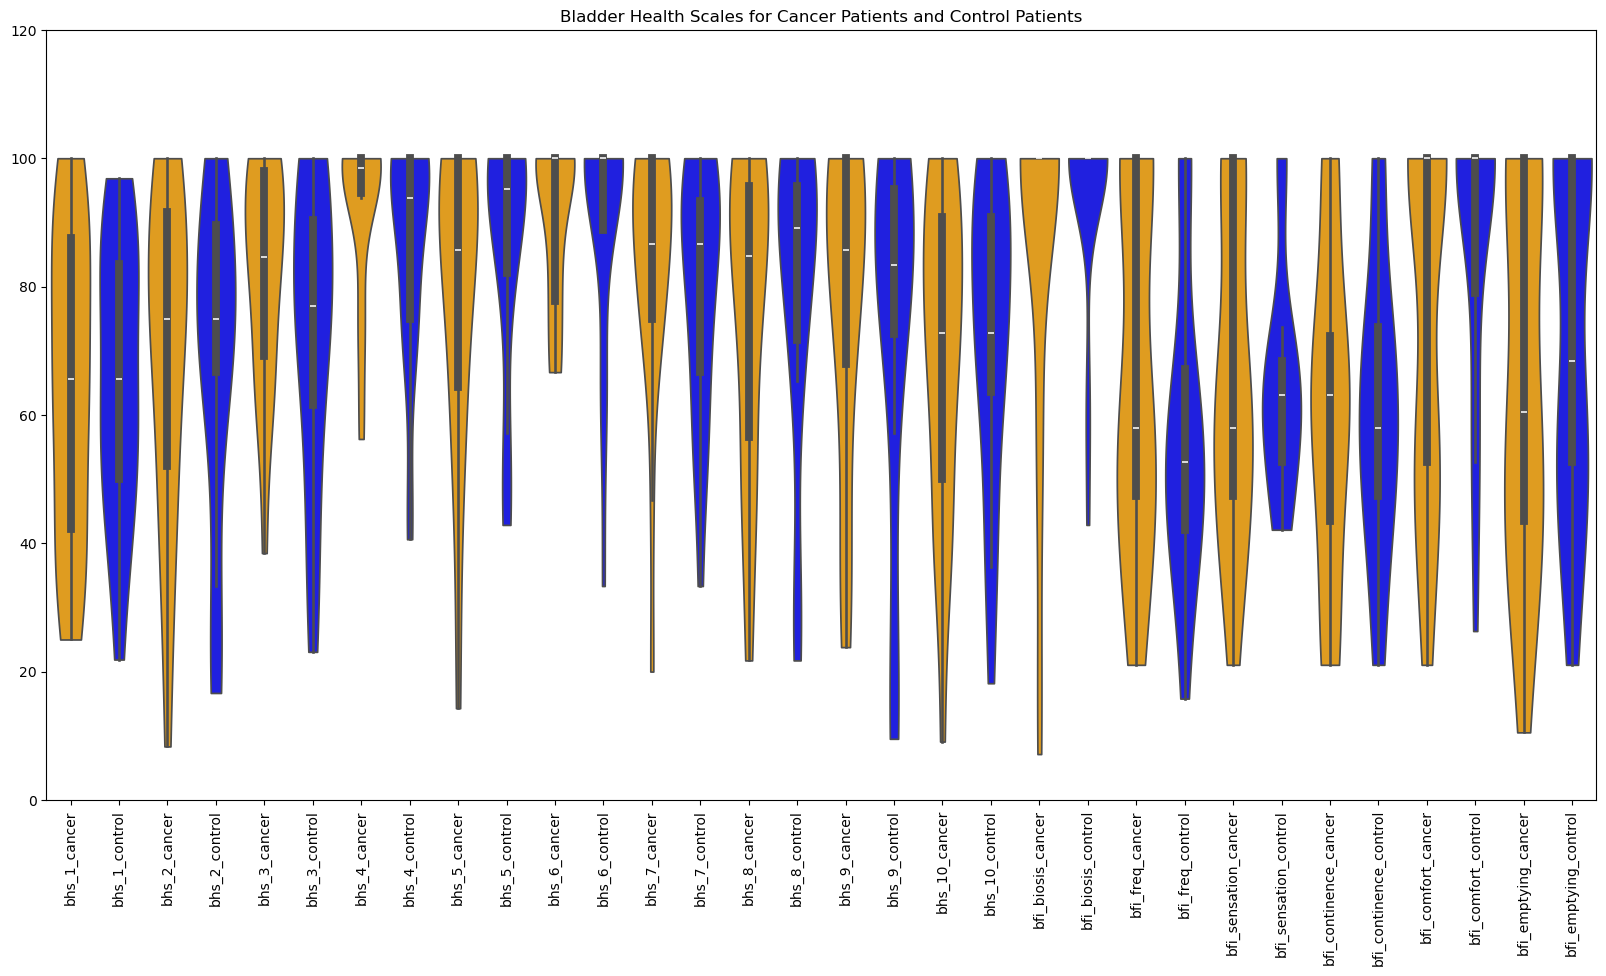

In [4]:
cancer_bladder_scales = patient_data_bladder_health.loc[cancer_patients]
control_bladder_scales = patient_data_bladder_health.loc[controls]

violin_plot_df = alternate_columns(cancer_bladder_scales.reset_index().drop(columns="participantid"), control_bladder_scales.reset_index().drop(columns="participantid"))

custom_palette = ['orange', 'blue'] * 16

plt.figure(figsize=(20, 10))
plt.ylim(0, 120)

sns.violinplot(data=violin_plot_df, palette=custom_palette, cut=0)
plt.xticks(rotation=90)
plt.title("Bladder Health Scales for Cancer Patients and Control Patients")


In [5]:
bladder_health_statistics = pd.DataFrame(index=bladder_health_cols, columns=["cancer_mean", "control_mean", "cancer_std", "control_std", "cancer_median", "control_median", "wilcoxon_statistic", "wilcoxon_p_value", "t_test_statistic", "t_test_p_value"])
for col in bladder_health_cols:
    cancer_mean = np.nanmean(patient_data_bladder_health.loc[cancer_patients][col])
    control_mean = np.nanmean(patient_data_bladder_health.loc[controls][col])
    cancer_std = np.nanstd(patient_data_bladder_health.loc[cancer_patients][col])
    control_std = np.nanstd(patient_data_bladder_health.loc[controls][col])
    cancer_median = np.nanmedian(patient_data_bladder_health.loc[cancer_patients][col])
    control_median = np.nanmedian(patient_data_bladder_health.loc[controls][col])
    wilcoxon_result = wilcoxon(patient_data_bladder_health.loc[cancer_patients][col], patient_data_bladder_health.loc[controls][col], alternative="two-sided", nan_policy="omit")
    t_test_result = stats.ttest_ind(patient_data_bladder_health.loc[cancer_patients][col], patient_data_bladder_health.loc[controls][col], equal_var=False, nan_policy="omit")
    bladder_health_statistics.loc[col, "cancer_mean"] = cancer_mean
    bladder_health_statistics.loc[col, "control_mean"] = control_mean
    bladder_health_statistics.loc[col, "cancer_std"] = cancer_std
    bladder_health_statistics.loc[col, "control_std"] = control_std
    bladder_health_statistics.loc[col, "cancer_median"] = cancer_median
    bladder_health_statistics.loc[col, "control_median"] = control_median
    bladder_health_statistics.loc[col, "wilcoxon_statistic"] = wilcoxon_result.statistic
    bladder_health_statistics.loc[col, "wilcoxon_p_value"] = wilcoxon_result.pvalue
    bladder_health_statistics.loc[col, "t_test_statistic"] = t_test_result.statistic
    bladder_health_statistics.loc[col, "t_test_p_value"] = t_test_result.pvalue

bladder_health_statistics.to_csv("../output_data/bladder_health_statistics.csv")    

In [6]:
bladder_health_adjusted_statistics = pd.DataFrame(index=bladder_health_cols_adj, columns=["cancer_mean", "control_mean", "cancer_std", "control_std", "cancer_median", "control_median", "wilcoxon_statistic", "wilcoxon_p_value", "t_test_statistic", "t_test_p_value"])
for col in bladder_health_cols_adj:
    cancer_mean = np.nanmean(patient_data_bladder_health_adj.loc[cancer_patients][col])
    control_mean = np.nanmean(patient_data_bladder_health_adj.loc[controls][col])
    cancer_std = np.nanstd(patient_data_bladder_health_adj.loc[cancer_patients][col])
    control_std = np.nanstd(patient_data_bladder_health_adj.loc[controls][col])
    cancer_median = np.nanmedian(patient_data_bladder_health_adj.loc[cancer_patients][col])
    control_median = np.nanmedian(patient_data_bladder_health_adj.loc[controls][col])
    wilcoxon_result = wilcoxon(patient_data_bladder_health_adj.loc[cancer_patients][col], patient_data_bladder_health_adj.loc[controls][col], alternative="two-sided", nan_policy="omit")
    t_test_result = stats.ttest_ind(patient_data_bladder_health_adj.loc[cancer_patients][col], patient_data_bladder_health_adj.loc[controls][col], equal_var=False, nan_policy="omit")
    bladder_health_adjusted_statistics.loc[col, "cancer_mean"] = cancer_mean
    bladder_health_adjusted_statistics.loc[col, "control_mean"] = control_mean
    bladder_health_adjusted_statistics.loc[col, "cancer_std"] = cancer_std
    bladder_health_adjusted_statistics.loc[col, "control_std"] = control_std
    bladder_health_adjusted_statistics.loc[col, "cancer_median"] = cancer_median
    bladder_health_adjusted_statistics.loc[col, "control_median"] = control_median
    bladder_health_adjusted_statistics.loc[col, "wilcoxon_statistic"] = wilcoxon_result.statistic
    bladder_health_adjusted_statistics.loc[col, "wilcoxon_p_value"] = wilcoxon_result.pvalue
    bladder_health_adjusted_statistics.loc[col, "t_test_statistic"] = t_test_result.statistic
    bladder_health_adjusted_statistics.loc[col, "t_test_p_value"] = t_test_result.pvalue

bladder_health_adjusted_statistics.to_csv("../output_data/bladder_health_adjusted_statistics.csv")   

In [12]:
for col in bladder_health_cols_adj:
    print(
    wilcoxon(patient_data_bladder_health_adj.loc[cancer_patients][col],
             patient_data_bladder_health_adj.loc[controls][col], alternative="two-sided", nan_policy="omit"))

WilcoxonResult(statistic=np.float64(75.0), pvalue=np.float64(0.2773551940917969))
WilcoxonResult(statistic=np.float64(77.0), pvalue=np.float64(0.3117942810058594))
WilcoxonResult(statistic=np.float64(67.5), pvalue=np.float64(0.16148425032759883))
WilcoxonResult(statistic=np.float64(72.0), pvalue=np.float64(0.2305126190185547))
WilcoxonResult(statistic=np.float64(88.0), pvalue=np.float64(0.5256171302573314))
WilcoxonResult(statistic=np.float64(53.0), pvalue=np.float64(0.15695518862262656))
WilcoxonResult(statistic=np.float64(64.0), pvalue=np.float64(0.13272666931152344))
WilcoxonResult(statistic=np.float64(81.5), pvalue=np.float64(0.38023107030487313))
WilcoxonResult(statistic=np.float64(60.0), pvalue=np.float64(0.09730720520019531))
WilcoxonResult(statistic=np.float64(83.0), pvalue=np.float64(0.4114239954629041))
WilcoxonResult(statistic=np.float64(126.0), pvalue=np.float64(1.0))


In [5]:
patient_data_bladder_health

,bhs_1,bhs_2,bhs_3,bhs_4,bhs_5,bhs_6,bhs_7,bhs_8,bhs_9,bhs_10,bfi_biosis,bfi_freq,bfi_sensation,bfi_continence,bfi_comfort,bfi_emptying
0,62.500,66.666667,76.923077,87.500,85.714286,NaN,86.666667,82.608696,61.904762,54.545455,50.000000,100.000000,68.421053,42.105263,63.157895,57.894737
1,62.500,66.666667,76.923077,90.625,85.714286,88.888889,73.333333,86.956522,71.428571,81.818182,100.000000,42.105263,100.000000,63.157895,63.157895,63.157895
2,50.000,41.666667,100.000000,81.250,100.000000,100.000000,46.666667,78.260870,52.380952,54.545455,100.000000,42.105263,21.052632,31.578947,31.578947,57.894737
3,65.625,75.000000,76.923077,84.375,95.238095,88.888889,53.333333,86.956522,85.714286,81.818182,100.000000,47.368421,36.842105,63.157895,100.000000,42.105263
4,93.750,91.666667,100.000000,100.000,100.000000,100.000000,100.000000,95.652174,100.000000,90.909091,57.142857,52.631579,52.631579,52.631579,52.631579,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
